# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pyportfolio/pyportfolioopt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/PyPortfolio/PyPortfolioOpt/blob/main/cookbook/4-Black-Litterman-Allocation.ipynb)

[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/pyportfolio/pyportfolioopt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/pyportfolio/pyportfolioopt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [195]:
!pip install matplotlib PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/pyportfolio/pyportfolioopt.git')
    os.chdir('PyPortfolioOpt/cookbook')

zsh:1: command not found: pip


In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [197]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [198]:
prices = pd.read_csv("data/prices.csv", parse_dates=True, index_col="Date")[tickers]
prices.tail()


,MSFT,AMZN,NAT,BAC,DPZ,DIS,KO,MCD,COST,SBUX
Date,,,,,,,,,,
2025-11-10,506.000000,248.399994,3.65,53.419998,407.589996,112.239998,70.519997,299.100006,915.559998,83.993195
2025-11-11,508.679993,249.100006,3.63,53.630001,409.230011,114.849998,71.610001,306.829987,913.859985,85.800140
2025-11-12,511.140015,244.199997,3.67,54.110001,403.760010,116.650002,71.510002,306.940002,914.000000,86.634125
2025-11-13,503.290009,237.580002,3.70,52.869999,408.679993,107.610001,71.070000,307.579987,925.080017,85.820007
2025-11-14,510.179993,234.690002,3.72,52.610001,410.160004,105.800003,71.160004,307.029999,922.979980,84.779999


In [199]:
market_prices = pd.read_csv("data/prices.csv", parse_dates=True, index_col="Date")["SPY"]
market_prices.head()


Date
1990-01-02   NaN
1990-01-03   NaN
1990-01-04   NaN
1990-01-05   NaN
1990-01-08   NaN
Name: SPY, dtype: float64

In [200]:
mcaps = pd.Series({'MSFT': 3791850569728,
 'AMZN': 2539781357568,
 'NAT': 787712448,
 'BAC': 386082930688,
 'DPZ': 13857754112,
 'DIS': 192114950144,
 'KO': 306102501376,
 'MCD': 219044429824,
 'COST': 409976176640,
 'SBUX': 98273632256})


## Constructing the prior

In [201]:
import pypfopt
pypfopt.__version__

'1.5.6'

In [202]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(3.411773623875034)

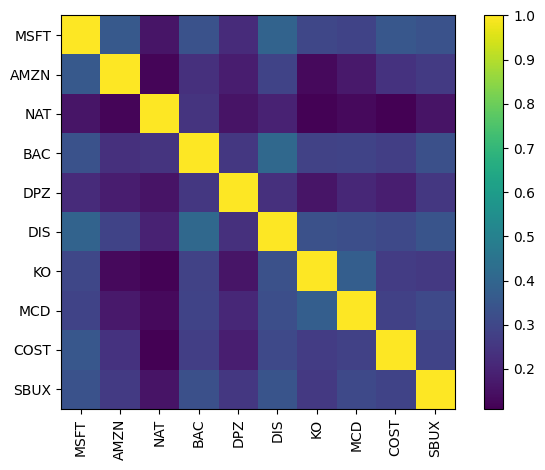

In [203]:
plotting.plot_covariance(S, plot_correlation=True);

In [204]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

MSFT    0.242524
AMZN    0.378604
NAT     0.074030
BAC     0.164686
DPZ     0.068981
DIS     0.133276
KO      0.066957
MCD     0.075469
COST    0.123549
SBUX    0.139438
dtype: float64

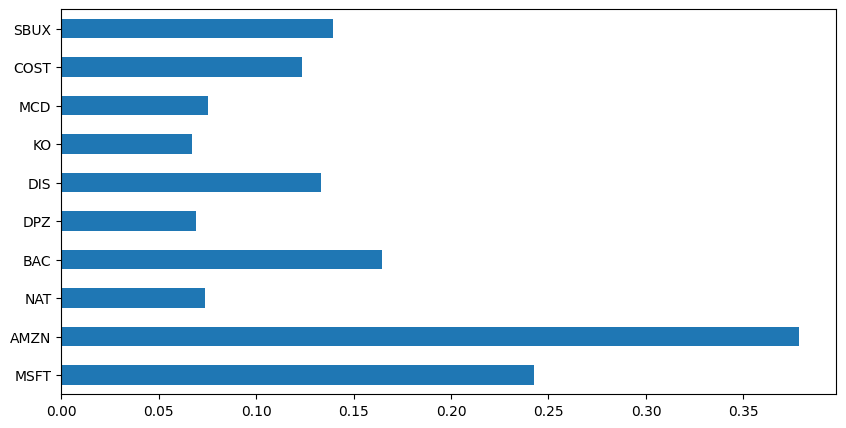

In [205]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [206]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [207]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]

In [208]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

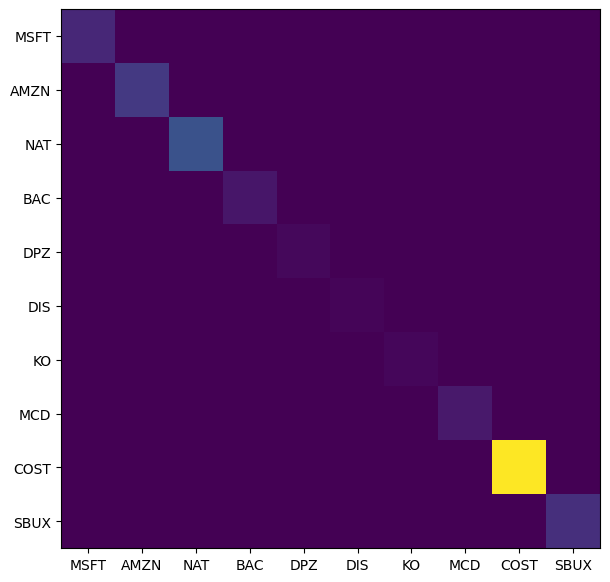

In [209]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [210]:
np.diag(bl.omega)

array([0.00810796, 0.01222231, 0.01854793, 0.00446609, 0.00156583,
       0.00102305, 0.00119764, 0.00491011, 0.07378793, 0.00981302])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [211]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [212]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [213]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [214]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

MSFT    0.110772
AMZN    0.235922
NAT     0.085746
BAC     0.161329
DPZ     0.135413
DIS     0.079986
KO      0.010339
MCD     0.094972
COST    0.078994
SBUX    0.107545
dtype: float64

We can visualise how this compares to the prior and our views:

In [215]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
MSFT,0.242524,0.110772,0.10
AMZN,0.378604,0.235922,0.10
NAT,0.074030,0.085746,0.50
BAC,0.164686,0.161329,0.30
DPZ,0.068981,0.135413,0.20
DIS,0.133276,0.079986,0.05
KO,0.066957,0.010339,-0.05
MCD,0.075469,0.094972,0.15
COST,0.123549,0.078994,0.05
SBUX,0.139438,0.107545,0.10


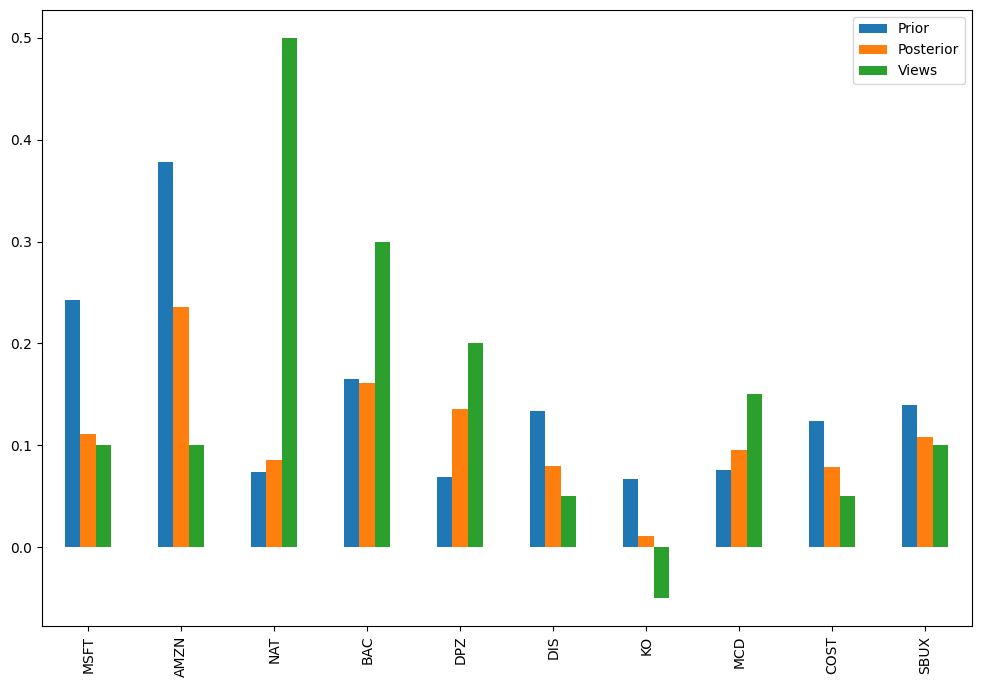

In [216]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

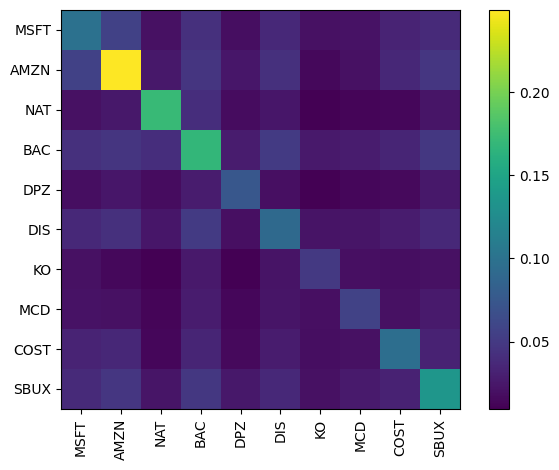

In [217]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [218]:
from pypfopt import EfficientFrontier, objective_functions

In [219]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/thomasschmelzer/projects/PyPortfolioOpt/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('MSFT', 0.09868),
             ('AMZN', 0.21708),
             ('NAT', 0.0747),
             ('BAC', 0.14668),
             ('DPZ', 0.14339),
             ('DIS', 0.06371),
             ('KO', 0.0),
             ('MCD', 0.09673),
             ('COST', 0.06795),
             ('SBUX', 0.09109)])

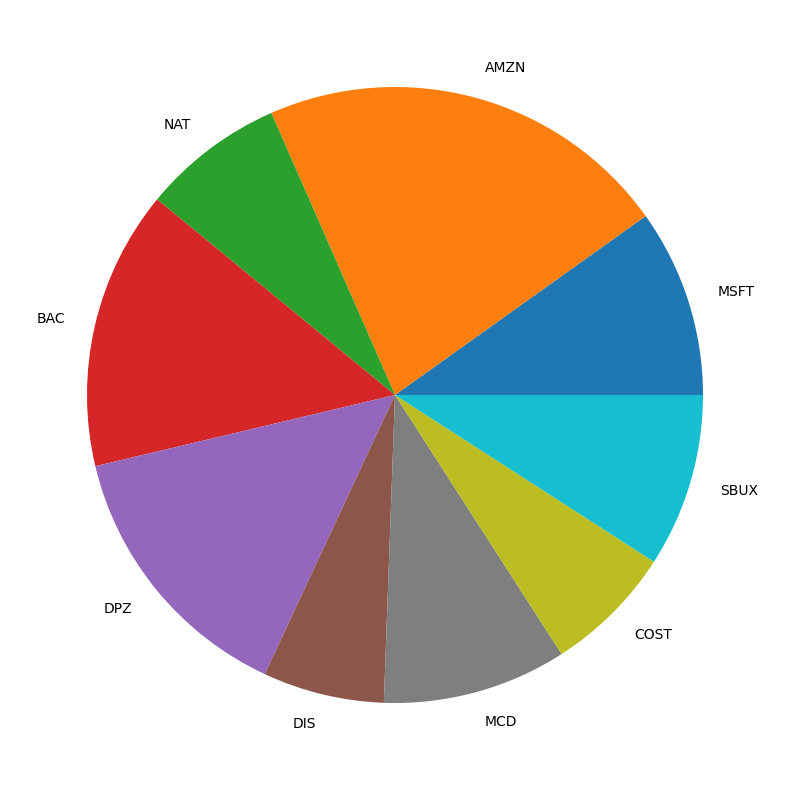

In [220]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [221]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $2.82


/Users/thomasschmelzer/projects/PyPortfolioOpt/pypfopt/discrete_allocation.py:276: FutureWarning: The default solver for lp_portfolio will change from ECOS_BB toNone, the cvxpy default solver, in release 1.7.0.To continue using ECOS_BB as the solver, please set solver='ECOS_BB' explicitly.
  warn(


{'MSFT': 4,
 'AMZN': 19,
 'NAT': 396,
 'BAC': 56,
 'DPZ': 7,
 'DIS': 12,
 'MCD': 7,
 'COST': 1,
 'SBUX': 22}